# Predicting customers who will "charge-off"

#Define charge-off
Steps:
1. Data Cleaning
2. Feature selection and transformation
3. Build the models
4. Test the models

Before starting: Install the imblearn python package on your computer! 
    
    Run the following in terminal: pip install -U imbalanced-learn

Let's load the libraries, connect to the database, parse dates and load all data in-memory. Make sure the three files database.sqlite, LCDataDictionary.xlsx, and loan.csv are all in the same folder as this notebook.

In [1]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline 
import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab module
%autosave 1000000
conn = sqlite3.connect('database.sqlite') # This runs sql within Python; will take a few minutes to run - literally, a few minutes
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] #takes a look at the columns, and cuts them up along columns, extracts columns so we can build a Python dataframe
df = pd.read_sql_query('select * from loan', con=conn, parse_dates = to_parse) #pandas feature, read SQL query into dataframe and load in-memory

Autosaving every 1000000 seconds


In [2]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('The shape is {}'.format(df.shape)) #tells us no of rows and columns of the df
print('Memory : {} Mb'.format(int(df.memory_usage(deep=False).sum() / 1000000))) #tells us how big the df is in Mb

The shape is (887383, 75)
Memory : 532 Mb


That's a fairly large dataframe! Perhaps we can reduce its size without loss by removing cells with little information. (What does "little information" mean?) This will serve to make the dataframe more manageable.

For this first assignment, we will remove columns whose cells are missing more than 60% of their values. 

## Data Cleaning


### Check which features have good coverage, e.g. more/less than N% missing values

In [4]:
check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))#.isnull() is a pandas feature that checks for missing values
#.sum() is a feature that will sum the previous feature of how many null values, with axis = 0 representing a vertical concatenation, which checks down the column of each dataframe. If axis = 1, this would be a horizontal concatenation checking each row instead of columns
#sort_values will then sort the results, with ascending = False meaning that results will be sorted is a descending order. This is all divided by the length of the dataframe, which has been converted to a float value
check_null[check_null>0.5] #outputs the feature and fraction of missing values

dti_joint                      0.999426
verification_status_joint      0.999424
annual_inc_joint               0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_cu_tl                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857977
mths_since_last_record         0.845554
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
dtype: float64

In [5]:
df.drop(check_null[check_null > 0.5].index, axis=1, inplace=True)
df.dropna(axis=0, thresh=30,inplace=True)

How many columns have more than 60% missing?

In [6]:
check_null[check_null>0.5].size #.size is a feature that returns how big a series is. Check_null is a series which checks for how many columns have more than 60% of their values missing, meaning that 20 columns have more than 60% of data missing
#check_null is the overall series we are checking, but we must specify [check_null>0.6] to capture that we are looking for specifically parts of the series that have >60% data missing

21

In [7]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables. The opposite is tail. You can add a parameter that says how many it shows.

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,171.62,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,119.66,NaT,2013-09-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,649.91,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,357.48,NaT,2015-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,67.79,2016-02-01,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [8]:
delete_me = ['id', 'member_id', 'policy_code', 'url', 'zip_code', 'addr_state',
            'pymnt_plan','emp_title','application_type','acc_now_delinq','title',
            'collections_12_mths_ex_med','collection_recovery_fee','next_pymnt_d']
#created a list of columns we want to delete
df = df.drop(delete_me , axis=1) 
#using the drop feature in pandas to drop the specified items in delete me, through a vertical concatenation to make sure we are specifying we want to delete columns
#inplace = True means that the data is renamed in place (it returns nothing), instead of creating a copy, which would happen if inplace = False

In [9]:
df.columns #load columns

Index(['index', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

In [10]:
print(df['loan_status'].value_counts()/len(df))

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050990
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64


In [11]:
df = df[df['loan_status'] != 'Current']

In [12]:
print(df['loan_status'].value_counts()/len(df))

Fully Paid                                             0.727322
Charged Off                                            0.158431
Late (31-120 days)                                     0.040585
Issued                                                 0.029622
In Grace Period                                        0.021894
Late (16-30 days)                                      0.008253
Does not meet the credit policy. Status:Fully Paid     0.006961
Default                                                0.004268
Does not meet the credit policy. Status:Charged Off    0.002665
Name: loan_status, dtype: float64


In [13]:
print(df['emp_length'].unique())

['10+ years' '< 1 year' '3 years' '9 years' '4 years' '5 years' '1 year'
 '6 years' '2 years' '7 years' '8 years' 'n/a']


In [14]:
df['empl_exp'] = 'experienced'
df.loc[df['emp_length'] == '< 1 year', 'empl_exp'] = 'NewGrad'

df.loc[df['emp_length'] == '1 year', 'empl_exp'] = 'Junior'
df.loc[df['emp_length'] == '2 years', 'empl_exp'] = 'Junior'            
df.loc[df['emp_length'] == '3 years', 'empl_exp'] = 'Junior'

df.loc[df['emp_length'] == '4 years', 'empl_exp'] = 'Mid'
df.loc[df['emp_length'] == '5 years', 'empl_exp'] = 'Mid'
df.loc[df['emp_length'] == '6 years', 'empl_exp'] = 'Mid'

df.loc[df['emp_length'] == '7 years', 'empl_exp'] = 'Senior'
df.loc[df['emp_length'] == '8 years', 'empl_exp'] = 'Senior'
df.loc[df['emp_length'] == '9 years', 'empl_exp'] = 'Senior'

df.loc[df['emp_length'] == 'n/a', 'empl_exp'] = 'unknown'

#delete the emp_length column 
df = df.drop('emp_length',axis=1)

In [15]:
df.dropna(axis=0, how = 'any', inplace = True)

In [16]:
print(df['loan_status'].value_counts()/len(df))

Fully Paid            0.734573
Charged Off           0.165971
Late (31-120 days)    0.054123
In Grace Period       0.028505
Late (16-30 days)     0.010914
Default               0.005684
Issued                0.000229
Name: loan_status, dtype: float64


In [17]:
#extract the target column and convert to Charged Off to 1 and the rest as 0
mask = (df.loan_status == 'Charged Off')
df['target'] = 0
df.loc[mask,'target'] = 1

target = df['target']
df = df.drop(['loan_status','target'],axis=1)

In [18]:
target.value_counts()

0    174764
1     34778
Name: target, dtype: int64

In [19]:
loan_categorical = df.select_dtypes(include=['object'], exclude=['float64','int64'])
features = df.select_dtypes(include=['float64','int64'])

In [20]:
for col in list(loan_categorical):
    dummy = pd.get_dummies(loan_categorical[col])
    features = pd.concat([features,dummy],axis=1)

In [21]:
from sklearn.linear_model import LogisticRegression #Imports logistic regression feature for analysis
from sklearn.model_selection import train_test_split #Imports train testing split, which split arrays or matrices into random train and test subsets
#chooses a random subset (a specified fraction) of X and y as a training sample, uses the remainder as a test sample. random_state sets the initial value.
from sklearn.model_selection import cross_val_score # Allows us to evaluate data by cross-validation
#Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: 
#a model that would just repeat the labels of the samples that it has just seen would have a perfect score but 
#would fail to predict anything useful on yet-unseen data. This situation is called overfitting. 
#To avoid it, it is common practice when performing a (supervised) machine learning experiment to 
#hold out part of the available data as a test set X_test, y_test. 
from sklearn import metrics #The sklearn.metrics module includes score functions, performance metrics 
#and pairwise metrics and distance computations.
from sklearn import preprocessing #The sklearn.preprocessing package provides several common utility 
#functions and transformer classes to change raw feature vectors into a representation that is more 
#suitable for the downstream estimators.
from sklearn.ensemble import RandomForestClassifier #import random forest classifier to use random forest


In [22]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'): #run_models is used below to run them
    #define the funciton run models, with the parameters:
    #X_train: training data set
    #Y_train: set of labels to all the data in x_train
    #The training set is a subset of the data set used to train a model.
    #X_test: test data set
    #y_test:  set of labels to all the data in x_test
    #model_type: specify the type of model we want to use
    #we select non-balanced for now, just to see how the initial model will fare
    
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10) #n_estimators sets the number of trees in forest for model
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    #Establish which methods we want to use - Logistic Regression and Random Forest - with the clfs line that creates a dictionary
    #of the two
    #cols establishes a list of the specific columns of metrics we want
    
    models_report = pd.DataFrame(columns = cols) #this is used to generate an empty model report
    conf_matrix = dict() #create a dictionary for the confidence matrix that assigns the confidence values to specific keys

    for clf, clf_name in zip(clfs.values(), clfs.keys()): 
        #establish a for loop saying that for each method name and value,

        clf.fit(X_train, y_train)
        #Train the model by fitting it to data, using the training data set as inputs
        
        y_pred = clf.predict(X_test) #the predicted labels that will be returned from 
        #.predict, which predicts target values of X given a model
        y_score = clf.predict_proba(X_test)[:,1] #the Target scores, 
        #can either be probability estimates of the positive class, confidence values, 
        #or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
        #obtained using .predict_proba, which is a
        #method of a (soft) classifier outputting the probability of the instance being in each of the classes.
        
        print('computing {} - {} '.format(clf_name, model_type)) #print output saying that the file is computing
        #specific model, which is why.format is used at end to pull name and model type to plug into statement

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        #create a dictionary of series names and keys assigning values for what each item is
        #the keys are the desired items we want in the end for our model analysis, with the values
        #explaining how each key is assigned/calculated 
        
        models_report = models_report.append(tmp, ignore_index = True)
        #append the tmp values to our currently empty model report
        #ignore_index = True means we ignore and do not use the index labels, do this as the report needs to show
        #only the names, not the methods for how each item is analyzed
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        #establish the confidence matrix, crosstab Compute a simple cross-tabulation of two (or more) factors.
        #Cross tabulation is a tool that allows you compare the relationship between two or more factors.
        #Can you tell what factors are we cross tabulating?
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        #the returns of the ROC curve, all three are arrays 
        #hence use of metrics.roc_curve, uses y test data and target scores to determine three return values
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
        #plotting dimensions and specifics for the result graph
    
    return models_report, conf_matrix
    #after running function, also give us models_report and confidence matrix for methods

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


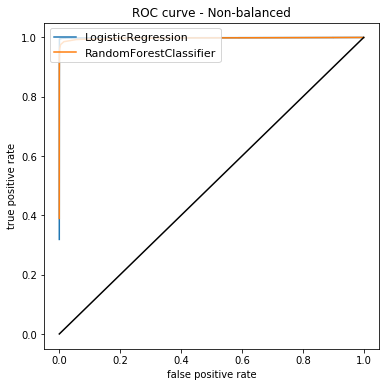

In [23]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split

#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

In [24]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,69856,5
1,122,13834


In [25]:
conf_matrix['RandomForestClassifier']

Predicted,0,1
True,,
0,69836,25
1,922,13034
